In [13]:
import os
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, AdaBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score


from tensorflow import keras
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [15]:
main_path = '/kaggle/input/mitbih-database'
window_size = 180
maximum_counting = 10000
classes = ['N', 'S', 'V', 'F', 'Q']
n_classes = len(classes)

X = list()
y = list()

In [16]:
filenames = next(os.walk(main_path))[2]

records = list()
annotations = list()
filenames.sort()

In [17]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(os.path.join(main_path, filename+file_extension))

    # *.txt
    else:
        annotations.append(os.path.join(main_path, filename + file_extension))

In [18]:
for r in range(0,len(records)):
    signals = []
    
    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(82977, 360) (82977,)


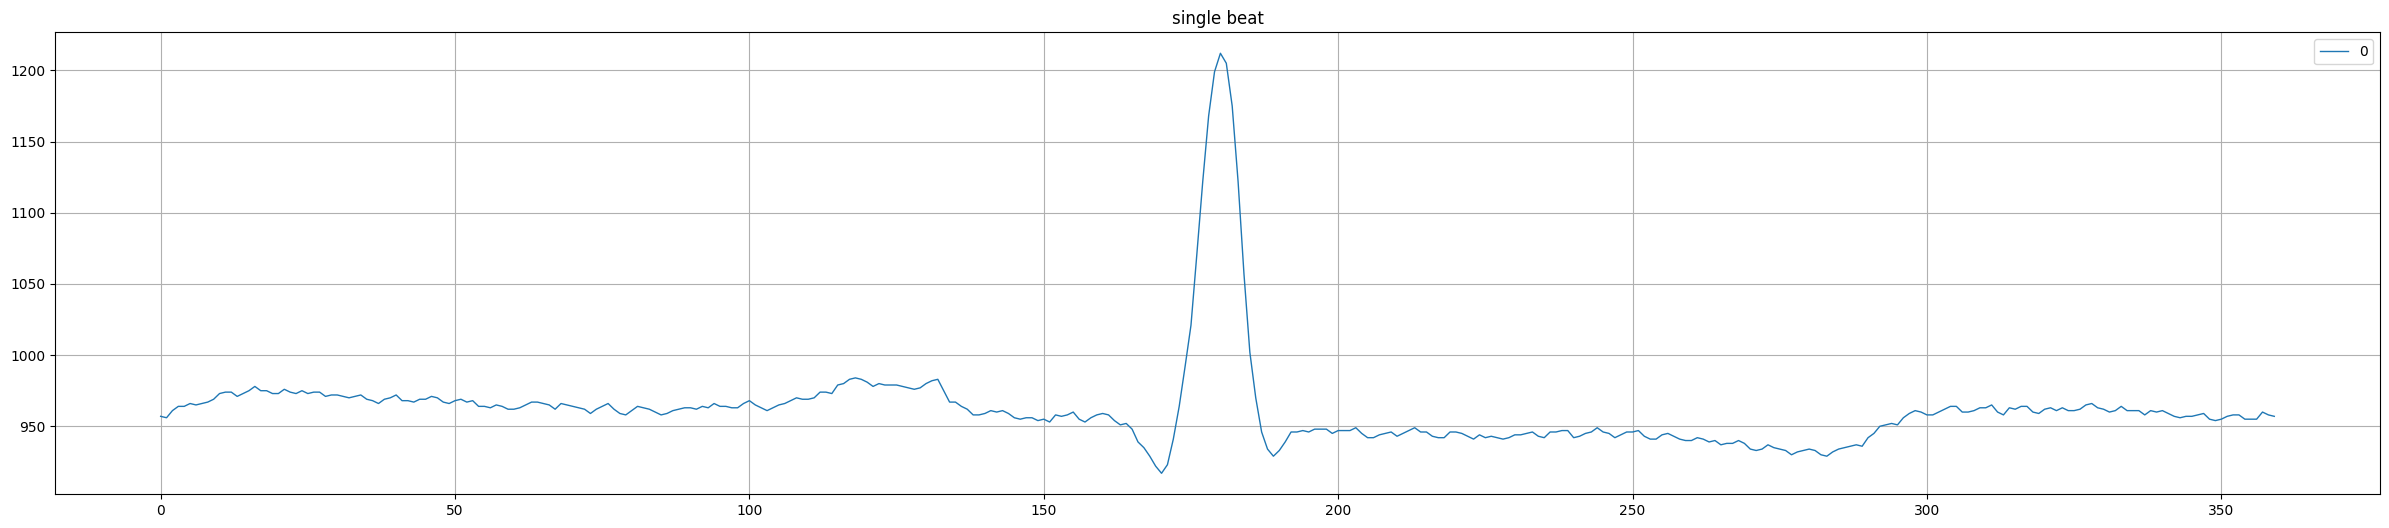

In [19]:
plt.title('single beat')
plt.plot(X[0])
plt.legend(f'{y[0]} - Normal')
plt.show()

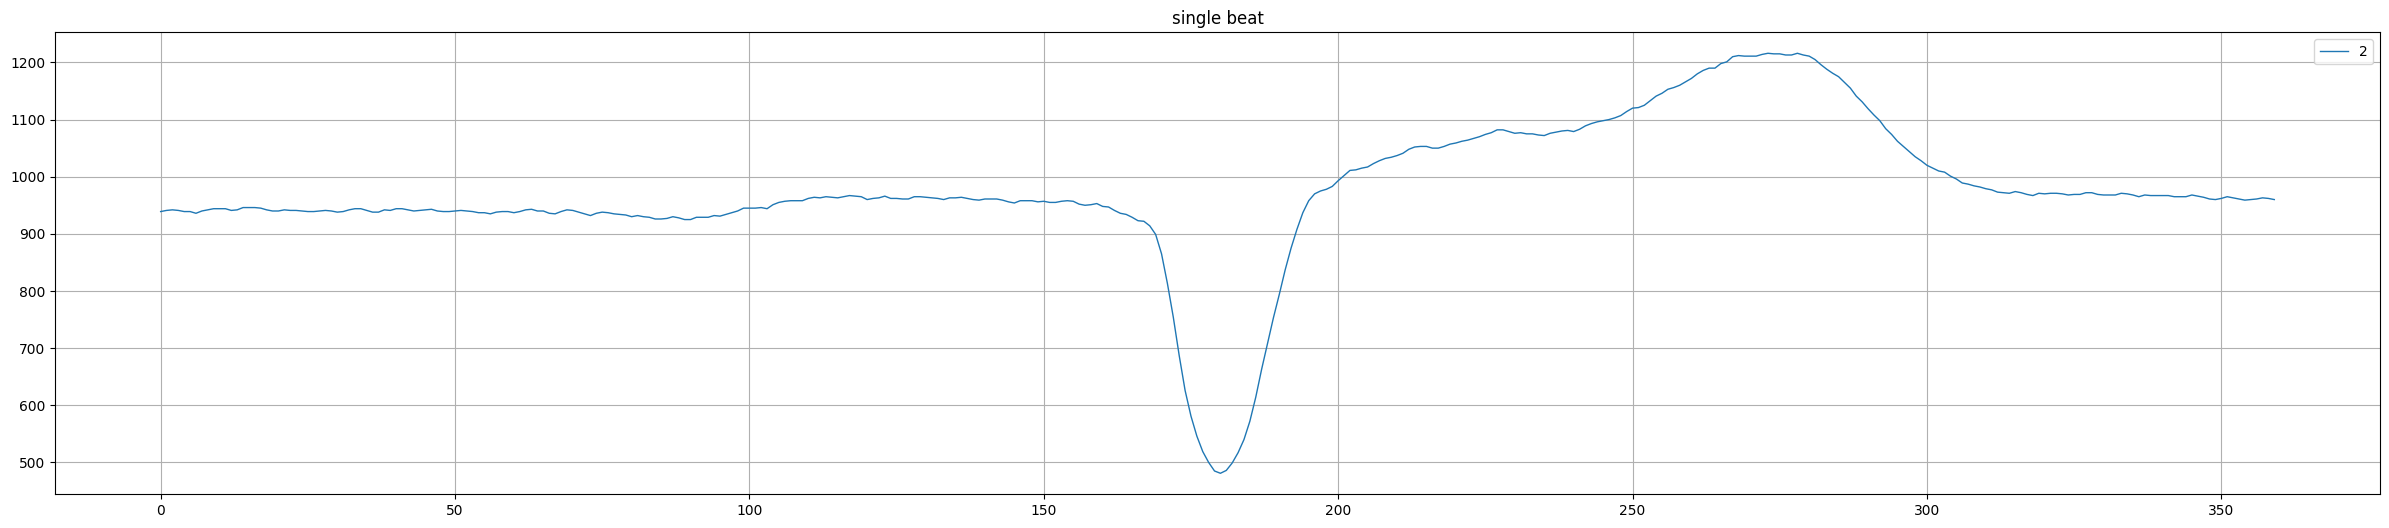

In [20]:
plt.title('single beat')
plt.plot(X[1879])
plt.legend(f'{y[1879]}')
plt.show()

In [21]:
unique_values, counts = np.unique(y, return_counts=True)
print(unique_values, counts)

[0 1 2 3 4] [75011     2  7129   802    33]


In [26]:
df = pd.DataFrame(X)

df['class'] = y
df['label'] = df['class'].replace({0:1, 1:-1, 2:-1, 3:-1, 4:-1})

features = list(range(360))
X, y = df[features], df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
features = list(range(360))
x1_train, x1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
class AnomalyMethods:

    def __init__(self):
        self.name = None
        self.age = None
    
    def using_knn(self, data, model, n_neighbors=3, percentile=95, predictions=True):
        model.fit(data)

        # Compute distances
        distances, indices = model.kneighbors(data, n_neighbors=n_neighbors)

        # Compute anomaly scores
        anomaly_scores = distances.mean(axis=1)

        # Set threshold
        threshold = np.percentile(anomaly_scores, percentile)

        labels=None
        if predictions:
            labels = np.where(anomaly_scores > threshold, -1, 1) # -1: anomaly, 1: inlier
            
        return model, labels
    
    def using_pca(self, data, model, variance_explained=0.95, predictions=True):
        pca = PCA(n_components=variance_explained)  # Retain 95% variance if variance_explained=0.95
        X_pca = pca.fit_transform(data)

        # Reconstruct data
        projected_data = pca.inverse_transform(X_pca)

        # Compute reconstruction error
        reconstruction_error = np.mean((data - projected_data) ** 2, axis=1)

        # Anomaly threshold (95th percentile)
        threshold = np.percentile(reconstruction_error, 95)

        labels = None
        if predictions:
            labels = np.where(reconstruction_error > threshold, -1, 1) # -1: anomaly, 1: inlier
        
        return pca, labels
    
    def using_adaboost(self, X_train, Y_train, X_test, model, predictions=True):
        model.fit(X_train, Y_train)

        labels = None
        if predictions:
            lables = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of anomaly class
        
        return model, labels

In [29]:
results = {'Method':[], 'Precision':[], 'Recall':[], 'F1-Score':[], 'Supervision':[]}

am = AnomalyMethods()

# 1.KNN
model = NearestNeighbors()
knn, knn_y_pred = am.using_knn(X_scaled, model)

knn_precision = precision_score(y, knn_y_pred, pos_label=-1)
knn_recall = recall_score(y, knn_y_pred, pos_label=-1)
knn_f1 = f1_score(y, knn_y_pred, pos_label=-1)
print(f'Method: KNN, Precision: {knn_precision}, Recall: {knn_recall}, F1: {knn_f1}')

results['Method'].append('KNN')
results['Precision'].append(knn_precision)
results['Recall'].append(knn_recall)
results['F1-Score'].append(knn_f1)
results['Supervision'].append('Unsupervised')


# 2.Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_y_pred = lof.fit_predict(X_scaled)

lof_precision = precision_score(y, lof_y_pred, pos_label=-1)
lof_recall = recall_score(y, lof_y_pred, pos_label=-1)
lof_f1 = f1_score(y, lof_y_pred, pos_label=-1)
print(f'Method: LOF, Precision: {lof_precision}, Recall: {lof_recall}, F1: {lof_f1}')

results['Method'].append('Local Outlier Factor')
results['Precision'].append(lof_precision)
results['Recall'].append(lof_recall)
results['F1-Score'].append(lof_f1)
results['Supervision'].append('Unsupervised')


# 3.One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm_y_pred = ocsvm.fit_predict(X_scaled)

ocsvm_precision = precision_score(y, ocsvm_y_pred, pos_label=-1)
ocsvm_recall = recall_score(y, ocsvm_y_pred, pos_label=-1)
ocsvm_f1 = f1_score(y, ocsvm_y_pred, pos_label=-1)
print(f'Method: One Class SVM, Precision: {ocsvm_precision}, Recall: {ocsvm_recall}, F1: {ocsvm_f1}')

results['Method'].append('One Class SVM')
results['Precision'].append(ocsvm_precision)
results['Recall'].append(ocsvm_recall)
results['F1-Score'].append(ocsvm_f1)
results['Supervision'].append('Unsupervised')


# 4.Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso_y_pred = iso.fit_predict(X_scaled)

iso_precision = precision_score(y, iso_y_pred, pos_label=-1)
iso_recall = recall_score(y, iso_y_pred, pos_label=-1)
iso_f1 = f1_score(y, iso_y_pred, pos_label=-1)
print(f'Method: Isolation Forest, Precision: {iso_precision}, Recall: {iso_recall}, F1: {iso_f1}')

results['Method'].append('Isolation Forest')
results['Precision'].append(iso_precision)
results['Recall'].append(iso_recall)
results['F1-Score'].append(iso_f1)
results['Supervision'].append('Unsupervised')


# 5.Elliptic Envelope
ell = EllipticEnvelope(contamination=0.05)
ell_y_pred = ell.fit_predict(X_scaled)

ell_precision = precision_score(y, ell_y_pred, pos_label=-1)
ell_recall = recall_score(y, ell_y_pred, pos_label=-1)
ell_f1 = f1_score(y, ell_y_pred, pos_label=-1)
print(f'Method: Elliptic Envelope, Precision: {ell_precision}, Recall: {ell_recall}, F1: {ell_f1}')

results['Method'].append('Elliptic Envelope')
results['Precision'].append(ell_precision)
results['Recall'].append(ell_recall)
results['F1-Score'].append(ell_f1)
results['Supervision'].append('Unsupervised')


# 6.PCA reconstruction error
pca = PCA(n_components=1)
pca, pca_y_pred = am.using_pca(X_scaled, pca)

pca_precision = precision_score(y, pca_y_pred, pos_label=-1)
pca_recall = recall_score(y, pca_y_pred, pos_label=-1)
pca_f1 = f1_score(y, pca_y_pred, pos_label=-1)
print(f'Method: PCA, Precision: {pca_precision}, Recall: {pca_recall}, F1: {pca_f1}')

results['Method'].append('PCA')
results['Precision'].append(pca_precision)
results['Recall'].append(pca_recall)
results['F1-Score'].append(pca_f1)
results['Supervision'].append('Unsupervised')


# 7.Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
scores = gmm.score_samples(X_scaled)
threshold = np.percentile(scores, 5)
gmm_y_pred = np.where(scores < threshold, -1, 1)

gmm_precision = precision_score(y, gmm_y_pred, pos_label=-1)
gmm_recall = recall_score(y, gmm_y_pred, pos_label=-1)
gmm_f1 = f1_score(y, gmm_y_pred, pos_label=-1)
print(f'Method: GMM, Precision: {gmm_precision}, Recall: {gmm_recall}, F1: {gmm_f1}')

results['Method'].append('GMM')
results['Precision'].append(gmm_precision)
results['Recall'].append(gmm_recall)
results['F1-Score'].append(gmm_f1)
results['Supervision'].append('Unsupervised')

# 8.K-Means distance method
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
distances = np.min(np.abs(X_scaled - kmeans.cluster_centers_[labels]), axis=1)
threshold = np.percentile(distances, 95)
kmeans_y_pred = np.where(distances > threshold, -1, 1)

kmeans_precision = precision_score(y, kmeans_y_pred, pos_label=-1)
kmeans_recall = recall_score(y, kmeans_y_pred, pos_label=-1)
kmeans_f1 = f1_score(y, kmeans_y_pred, pos_label=-1)
print(f'Method: K-Means, Precision: {kmeans_precision}, Recall: {kmeans_recall}, F1: {kmeans_f1}')

results['Method'].append('K Means')
results['Precision'].append(kmeans_precision)
results['Recall'].append(kmeans_recall)
results['F1-Score'].append(kmeans_f1)
results['Supervision'].append('Unsupervised')


# 9.DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=75)
labels = dbscan.fit_predict(X_scaled)
DBSCAN_y_pred = np.where(labels == -1, -1, 1)

DBSCAN_precision = precision_score(y, DBSCAN_y_pred, pos_label=-1)
DBSCAN_recall = recall_score(y, DBSCAN_y_pred, pos_label=-1)
DBSCAN_f1 = f1_score(y, DBSCAN_y_pred, pos_label=-1)
print(f'Method: DBSCAN, Precision: {DBSCAN_precision}, Recall: {DBSCAN_recall}, F1: {DBSCAN_f1}')

results['Method'].append('DBSCAN')
results['Precision'].append(DBSCAN_precision)
results['Recall'].append(DBSCAN_recall)
results['F1-Score'].append(DBSCAN_f1)
results['Supervision'].append('Unsupervised')


# 10.Autoencoder
input_dim = X_scaled.shape[1]
autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(input_dim, activation=None)
])
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16, verbose=0)
recon = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - recon), axis=1)
threshold = np.percentile(mse, 95)
auto_y_pred = np.where(mse > threshold, -1, 1)

auto_precision = precision_score(y, auto_y_pred, pos_label=-1)
auto_recall = recall_score(y, auto_y_pred, pos_label=-1)
auto_f1 = f1_score(y, auto_y_pred, pos_label=-1)
print(f'Method: Autoencoder, Precision: {auto_precision}, Recall: {auto_recall}, F1: {auto_f1}')

results['Method'].append('Autoencoder')
results['Precision'].append(auto_precision)
results['Recall'].append(auto_recall)
results['F1-Score'].append(auto_f1)
results['Supervision'].append('Unsupervised')


# 11.AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(x1_train, y1_train)
y_pred_ada = ada.predict(x1_test)

ada_precision = precision_score(y1_test, y_pred_ada, pos_label=-1)
ada_recall = recall_score(y1_test, y_pred_ada, pos_label=-1)
ada_f1 = f1_score(y1_test, y_pred_ada, pos_label=-1)
print(f'Method: AdaBoost, Precision: {ada_precision}, Recall: {ada_recall}, F1: {ada_f1}')

results['Method'].append('AdaBoost')
results['Precision'].append(ada_precision)
results['Recall'].append(ada_recall)
results['F1-Score'].append(ada_f1)
results['Supervision'].append('Semi-supervised')

Method: KNN, Precision: 0.4220294046758255, Recall: 0.21980918905347727, F1: 0.2890631448617416
Method: LOF, Precision: 0.21378645456736564, Recall: 0.11134822997740397, F1: 0.1464300453982666
Method: One Class SVM, Precision: 0.5462205103514685, Recall: 0.2848355510921416, F1: 0.37442244224422444
Method: Isolation Forest, Precision: 0.4940949626416004, Recall: 0.2573437107707758, F1: 0.3384234420140322


/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7785.856705802950273 > -7795.238217968385470). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7859.439295098615730 > -7870.849442438155165). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7846.586885326977608 > -7848.971849486544670). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
/usr

Method: Elliptic Envelope, Precision: 0.48879248011569054, Recall: 0.2545819733868943, F1: 0.3347915806851011
Method: PCA, Precision: 0.5762834417932032, Recall: 0.300150640220939, F1: 0.3947172926124639
Method: GMM, Precision: 0.2496987225837551, Recall: 0.13005272407732865, F1: 0.17102765167148162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Method: K-Means, Precision: 0.08845504940949626, Recall: 0.04607080090384132, F1: 0.06058605035080478
Method: DBSCAN, Precision: 0.09600250671872929, Recall: 1.0, F1: 0.17518665537754416


2025-10-24 10:13:51.893998: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2594/2594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Method: Autoencoder, Precision: 0.5852012533140516, Recall: 0.30479538036655784, F1: 0.4008254230293025
Method: AdaBoost, Precision: 0.923130677847659, Recall: 0.8292529817953547, F1: 0.8736772486772488


In [32]:
metrics_df = pd.DataFrame(results)
metrics_df

,Method,Precision,Recall,F1-Score,Supervision
0,KNN,0.422029,0.219809,0.289063,Unsupervised
1,Local Outlier Factor,0.213786,0.111348,0.146430,Unsupervised
2,One Class SVM,0.546221,0.284836,0.374422,Unsupervised
3,Isolation Forest,0.494095,0.257344,0.338423,Unsupervised
4,Elliptic Envelope,0.488792,0.254582,0.334792,Unsupervised
5,PCA,0.576283,0.300151,0.394717,Unsupervised
6,GMM,0.249699,0.130053,0.171028,Unsupervised
7,K Means,0.088455,0.046071,0.060586,Unsupervised
8,DBSCAN,0.096003,1.000000,0.175187,Unsupervised
9,Autoencoder,0.585201,0.304795,0.400825,Unsupervised


In [33]:
metrics_df.to_csv('mitbih_results.csv')